# cmQTL pilot variance analysis

### May 29, 2019

In [12]:
library(lme4)
library(ggplot2)
library(ggrepel)
library(ggthemes)
library(tidyr)
library(reshape2)


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



## All cells

In [2]:
## Load data – normalized and aggregated across all cells in each well
pilot.data.6 <- read.csv("/data/srlab/amariuta/jobs/cmQTL/cmQTL/0.pilot-determine-conditions/data/BR00103267_normalized_variable_selected.csv")
pilot.metadata.6 <- pilot.data.6[,1:8]
pilot.data.6 <- pilot.data.6[,9:ncol(pilot.data.6)]

In [3]:
pilot.data.24 <- read.csv("/data/srlab/amariuta/jobs/cmQTL/cmQTL/0.pilot-determine-conditions/data/BR00103268_normalized_variable_selected.csv")
pilot.metadata.24 <- pilot.data.24[,1:8]
pilot.data.24 <- pilot.data.24[,9:ncol(pilot.data.24)]

In [4]:
## Load data – number of isolated cells in each well
well_counts <- read.delim("/data/srlab/anathan/cmQTL/well_cell_counts.tsv", sep = "\t")
head(well_counts)

X,Metadata_Well,cell_count,batch_id,sc_type
<int>,<fct>,<int>,<fct>,<fct>
0,A01,152,BR00103267,all
1,A02,236,BR00103267,all
2,A03,847,BR00103267,all
3,A04,1205,BR00103267,all
4,A05,119,BR00103267,all
5,A06,186,BR00103267,all


In [5]:
prop.isolated.6 <- sapply(names(table(well_counts$Metadata_Well)), function(x) {
    return(well_counts$cell_count[well_counts$Metadata_Well == x & well_counts$sc_type == "isolated" & well_counts$batch_id == "BR00103267"]/well_counts$cell_count[well_counts$Metadata_Well == x & well_counts$sc_type == "all" & well_counts$batch_id == "BR00103267"])
})
prop.isolated.24 <- sapply(names(table(well_counts$Metadata_Well)), function(x) {
    return(well_counts$cell_count[well_counts$Metadata_Well == x & well_counts$sc_type == "isolated" & well_counts$batch_id == "BR00103268"]/well_counts$cell_count[well_counts$Metadata_Well == x & well_counts$sc_type == "all" & well_counts$batch_id == "BR00103268"])
})
head(prop.isolated.6)

A01        A02        A03        A04        A05        A06 
0.54605263 0.38983051 0.08972845 0.04647303 0.69747899 0.54838710

### Relationship between proportion isolated and co-variates

In [6]:
## Mixed effects model to measure variance in isolated cell proportion explained by cell line random effect
summary(lmer(prop.isolated.6 ~ 1 + (1 | pilot.metadata.6$Metadata_line_ID) + (1 | pilot.metadata.6$Metadata_plating_density)))


Linear mixed model fit by REML ['lmerMod']
Formula: prop.isolated.6 ~ 1 + (1 | pilot.metadata.6$Metadata_line_ID) +  
    (1 | pilot.metadata.6$Metadata_plating_density)

REML criterion at convergence: -691

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1802 -0.6900 -0.2498  0.5008  4.0551 

Random effects:
 Groups                                    Name        Variance Std.Dev.
 pilot.metadata.6$Metadata_line_ID         (Intercept) 0.024804 0.15749 
 pilot.metadata.6$Metadata_plating_density (Intercept) 0.008017 0.08954 
 Residual                                              0.008556 0.09250 
Number of obs: 384, groups:  
pilot.metadata.6$Metadata_line_ID, 6; pilot.metadata.6$Metadata_plating_density, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.20160    0.07849   2.568

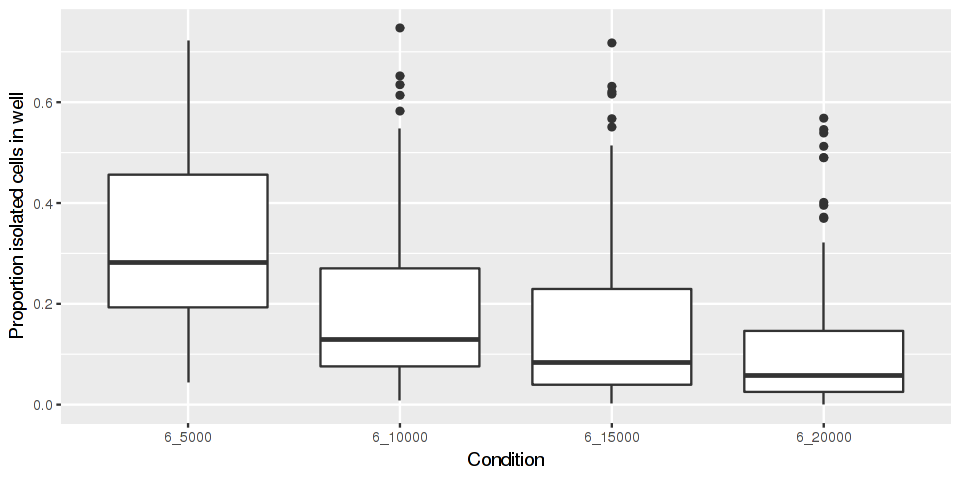

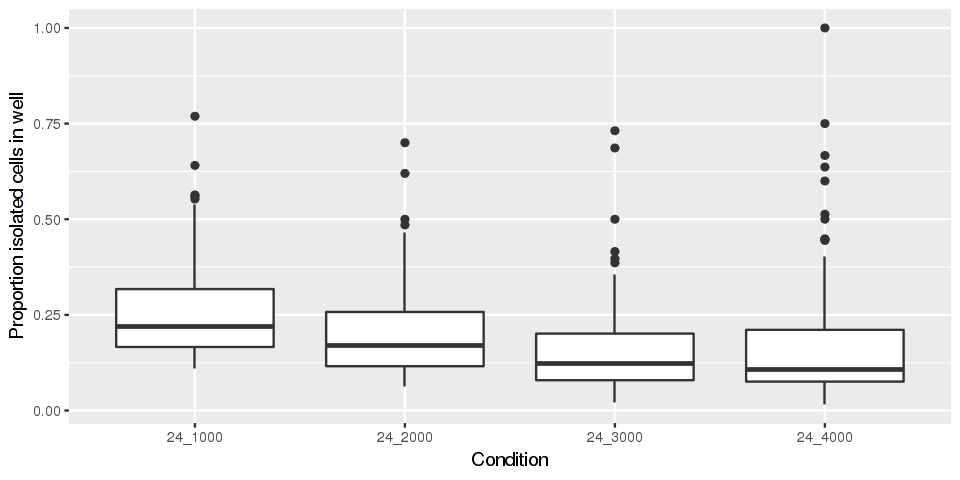

In [197]:
options(repr.plot.height = 4, repr.plot.width = 8)
ggplot(as.data.frame(prop.isolated.6), aes(x = paste0(pilot.metadata.6$Metadata_timepoint, "_", pilot.metadata.6$Metadata_plating_density), y = prop.isolated.6)) +
    geom_boxplot() +
    xlab("Condition") + ylab("Proportion isolated cells in well") +
    scale_x_discrete(limits=c("6_5000", "6_10000", "6_15000", "6_20000"))

options(repr.plot.height = 4, repr.plot.width = 8)
ggplot(as.data.frame(prop.isolated.24), aes(x = paste0(pilot.metadata.24$Metadata_timepoint, "_", pilot.metadata.24$Metadata_plating_density), y = prop.isolated.24)) +
    geom_boxplot() +
    xlab("Condition") + ylab("Proportion isolated cells in well") +
    scale_x_discrete(limits=c("24_1000", "24_2000", "24_3000", "24_4000"))

### Variance analysis, by condition

In [6]:
run_var_condition <- function(density, data, metadata) {
    idx <- metadata$Metadata_plating_density == density
    metadata.subset <- metadata$Metadata_line_ID[idx]
    data.subset <- data[idx,]
        
    suppressMessages(suppressWarnings(pilot.prop.var <- apply(data.subset, 2, function(x){as.data.frame(VarCorr(lmer(x ~ 1 + (1 | metadata.subset))))$vcov})))
    row.names(pilot.prop.var) <- c("Cellline", "Residual")

    return(apply(pilot.prop.var, 2, function(x) {x[1]/sum(x)}))
}

In [7]:
timepoint.6 <- sapply(c(5000, 10000, 15000, 20000), run_var_condition, pilot.data.6, pilot.metadata.6)

In [8]:
timepoint.24 <- sapply(c(1000, 2000, 3000, 4000), run_var_condition, pilot.data.24, pilot.metadata.24)

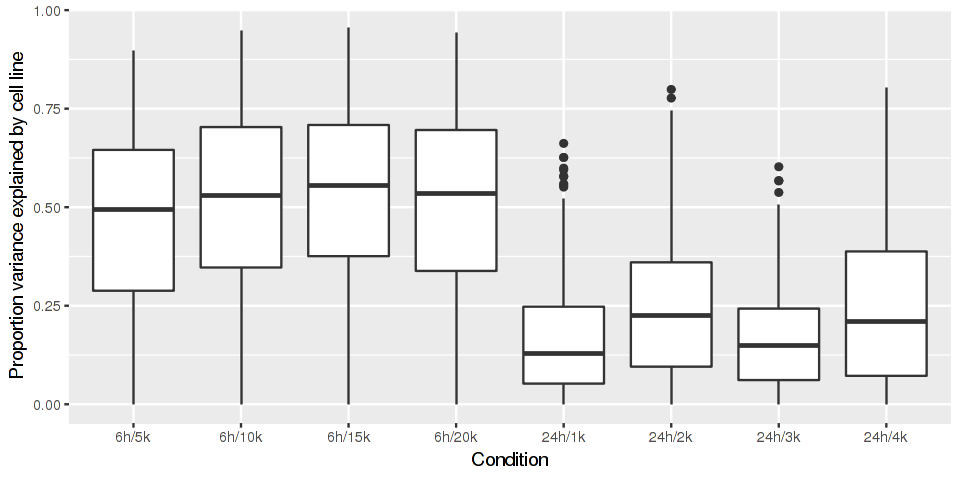

In [13]:
options(repr.plot.height = 4, repr.plot.width = 8)
ggplot(melt(cbind(timepoint.6, timepoint.24)), aes(x = factor(Var2), y = value)) +
    geom_boxplot() +
    xlab("Condition") + ylab("Proportion variance explained by cell line") +
    scale_x_discrete(labels = c("6h/5k", "6h/10k", "6h/15k", "6h/20k", "24h/1k", "24h/2k", "24h/3k", "24h/4k"))

### Chosen condition: 6h/10k cells

In [14]:
pilot.data.6.subset <- pilot.data.6[pilot.metadata.6$Metadata_plating_density == 10000,]
pilot.metadata.6.subset <- pilot.metadata.6$Metadata_line_ID[pilot.metadata.6$Metadata_plating_density == 10000]

suppressMessages(suppressWarnings(pilot.prop.var <- apply(pilot.data.6.subset, 2, function(x){as.data.frame(VarCorr(lmer(x ~ 1 + (1 | pilot.metadata.6.subset))))$vcov})))
row.names(pilot.prop.var) <- c("Cellline", "Residual")

pilot.prop.var.6.cellline <- apply(pilot.prop.var, 2, function(x){x[1]/sum(x)})
pilot.prop.var.6.residual <- apply(pilot.prop.var, 2, function(x){x[2]/sum(x)})

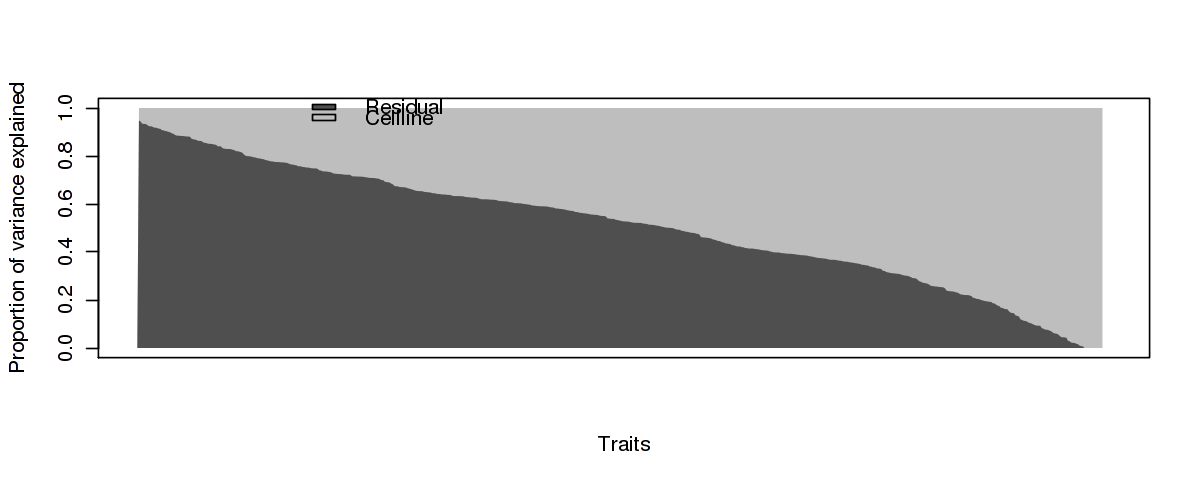

In [16]:
options(repr.plot.height = 4, repr.plot.width = 10)

plot(0, type = 'n', xlim = c(0,ncol(pilot.prop.var) + 5), ylim = c(0,1), xaxt = 'n', xlab = "Traits", ylab = "Proportion of variance explained")
polygon(x=c(0,1:ncol(pilot.prop.var),ncol(pilot.prop.var)), y = c(0,pilot.prop.var.6.cellline[order(pilot.prop.var.6.residual)],0) + c(0,pilot.prop.var.6.residual[order(pilot.prop.var.6.residual)],0), col="gray", border=NA)
polygon(x=c(0,1:ncol(pilot.prop.var),ncol(pilot.prop.var)), y = c(0,pilot.prop.var.6.cellline[order(pilot.prop.var.6.residual)],0), col="gray31", border=NA)
legend(ncol(pilot.prop.var)-500,1.05,legend=row.names(pilot.prop.var)[c(2,1)], bty = 'n', fill = c("gray31", "gray"))

In [17]:
pilot.pca.6 <- irlba::prcomp_irlba(pilot.data.6.subset, 30)

In [18]:
## Code from Ilya Korsunsky
do_pvca <- function(eigen.mat, meta, n.eigen) {
    meta <- as.data.frame(meta)
    npc.in <- n.eigen
    pred.list <- colnames(meta)
    meta <- droplevels(meta)
    n.preds <- ncol(meta) + 1
    ran.pred.list <- c()
    for (i in 1:ncol(meta)) {
        ran.pred.list <- c(ran.pred.list, paste0("(1|", pred.list[i], ")"))
    }

    formula <- paste(ran.pred.list, collapse = " + ")
    formula <- paste("pc", formula, sep = " ~ ")
    ran.var.mat <- NULL
    for (i in 1:npc.in) {
        message(sprintf("BEGIN ITER %d", i))
        dat <- cbind(eigen.mat[, i], meta)
        colnames(dat) <- c("pc", colnames(meta))
        Rm1ML <- lme4::lmer(formula, dat, REML = TRUE, verbose = FALSE, 
            na.action = na.omit)
        var.vec <- unlist(VarCorr(Rm1ML))
        ran.var.mat <- rbind(ran.var.mat, c(var.vec[pred.list], resid = sigma(Rm1ML)^2))
    }
    ran.var.mat.std <- ran.var.mat/rowSums(ran.var.mat)
    ran.var.mat.std %>% data.frame() %>% tibble::rowid_to_column("pc") %>% 
        dplyr::mutate(pc_str = paste0("PC", pc)) %>%
        tidyr::gather(variable, val, -pc, -pc_str)     
    
}

In [19]:
head(pilot.metadata.6)

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_timepoint
<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>
BR00103267,A01,BR00103267,cmQTL1-4_mt,A01,5000,A,6
BR00103267,A02,BR00103267,cmQTL1-4_mt,A02,5000,A,6
BR00103267,A03,BR00103267,cmQTL1-4_mt,A03,15000,B,6
BR00103267,A04,BR00103267,cmQTL1-4_mt,A04,15000,B,6
BR00103267,A05,BR00103267,cmQTL1-4_mt,A05,5000,E,6
BR00103267,A06,BR00103267,cmQTL1-4_mt,A06,5000,E,6


In [20]:
pilot.pvca.6 <- do_pvca(as.matrix(pilot.pca.6$x), pilot.metadata.6.subset, 30)


BEGIN ITER 1
singular fit
BEGIN ITER 2
BEGIN ITER 3
BEGIN ITER 4
BEGIN ITER 5
BEGIN ITER 6
BEGIN ITER 7
BEGIN ITER 8
BEGIN ITER 9
BEGIN ITER 10
BEGIN ITER 11
BEGIN ITER 12
BEGIN ITER 13
BEGIN ITER 14
BEGIN ITER 15
BEGIN ITER 16
singular fit
BEGIN ITER 17
singular fit
BEGIN ITER 18
singular fit
BEGIN ITER 19
BEGIN ITER 20
singular fit
BEGIN ITER 21
singular fit
BEGIN ITER 22
singular fit
BEGIN ITER 23
singular fit
BEGIN ITER 24
singular fit
BEGIN ITER 25
singular fit
BEGIN ITER 26
singular fit
BEGIN ITER 27
singular fit
BEGIN ITER 28
singular fit
BEGIN ITER 29
singular fit
BEGIN ITER 30
singular fit


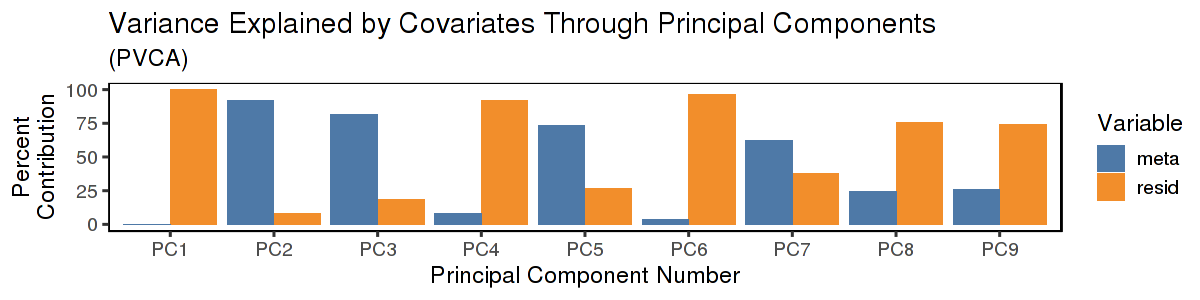

In [21]:
options(repr.plot.height = 2.5, repr.plot.width = 10)
pilot.pvca.6 %>% 
    subset(pc < 10) %>%
    ggplot(aes(pc_str, val * 100, fill = variable)) + 
#     ggplot(aes(reorder(sprintf("%s (%.0f%%)", pc_str, 100 * var_explained), pc), var_explained * val * 100, fill = variable_nice)) + 
#     ggplot(aes(reorder(pc_str, pc), val * 100, fill = variable_nice)) + 
        geom_bar(stat = "identity", position = position_dodge()) + 
        theme_tufte(base_size = 14) + theme(panel.background = element_rect()) + 
        scale_fill_tableau() + 
        labs(y = "Percent\nContribution", x = "Principal Component Number", fill = "Variable", 
             title = "Variance Explained by Covariates Through Principal Components", 
             subtitle = "(PVCA)") 

## Only isolated

In [22]:
## Load data – aggregated over only isolated or only colonized cells in each well
pilot.data.6.isolated <- read.csv("/data/srlab/amariuta/jobs/cmQTL/cmQTL/0.pilot-determine-conditions/data/BR00103267_isolated_normalized_variable_selected.csv")
pilot.data.6.colony <- read.csv("/data/srlab/amariuta/jobs/cmQTL/cmQTL/0.pilot-determine-conditions/data/BR00103267_colony_normalized_variable_selected.csv")
pilot.metadata.6.isolated <- pilot.data.6.isolated[,1:8]
pilot.metadata.6.colony <- pilot.data.6.colony[,1:8]
pilot.data.6.isolated <- pilot.data.6.isolated[,9:ncol(pilot.data.6.isolated)]
pilot.data.6.colony <- pilot.data.6.colony[,9:ncol(pilot.data.6.colony)]

In [23]:
pilot.data.24.isolated <- read.csv("/data/srlab/amariuta/jobs/cmQTL/cmQTL/0.pilot-determine-conditions/data/BR00103268_isolated_normalized_variable_selected.csv")
pilot.data.24.colony <- read.csv("/data/srlab/amariuta/jobs/cmQTL/cmQTL/0.pilot-determine-conditions/data/BR00103268_colony_normalized_variable_selected.csv")
pilot.metadata.24.isolated <- pilot.data.24.isolated[,1:8]
pilot.metadata.24.colony <- pilot.data.24.colony[,1:8]
pilot.data.24.isolated <- pilot.data.24.isolated[,9:ncol(pilot.data.24.isolated)]
pilot.data.24.colony <- pilot.data.24.colony[,9:ncol(pilot.data.24.colony)]

In [24]:
## Remove traits with NA values
pilot.data.6.isolated <- pilot.data.6.isolated[,!apply(pilot.data.6.isolated, 2, function(x) {any(is.na(x))})]
pilot.data.6.colony <- pilot.data.6.colony[,!apply(pilot.data.6.colony, 2, function(x) {any(is.na(x))})]

pilot.data.24.isolated <- pilot.data.24.isolated[,!apply(pilot.data.24.isolated, 2, function(x) {any(is.na(x))})]
pilot.data.24.colony <- pilot.data.24.colony[,!apply(pilot.data.24.colony, 2, function(x) {any(is.na(x))})]

### Variance analysis, by condition

In [25]:
timepoint.6.isolated <- sapply(c(5000, 10000, 15000, 20000), run_var_condition, pilot.data.6.isolated, pilot.metadata.6.isolated)

In [26]:
timepoint.24.isolated <- sapply(c(1000, 2000, 3000, 4000), run_var_condition, pilot.data.24.isolated, pilot.metadata.24.isolated)

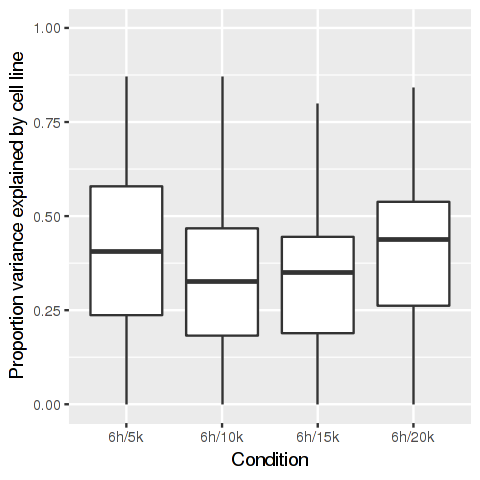

In [27]:
options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(melt(cbind(timepoint.6.isolated)), aes(x = factor(Var2), y = value)) +
    geom_boxplot() +
    xlab("Condition") + ylab("Proportion variance explained by cell line") +
    scale_x_discrete(labels = c("6h/5k", "6h/10k", "6h/15k", "6h/20k")) +
    ylim(0,1)

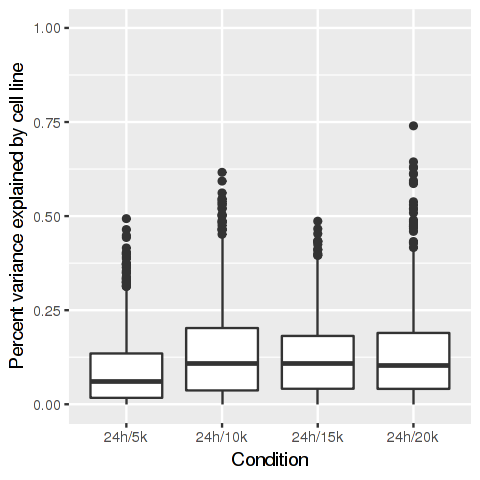

In [28]:
options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(melt(cbind(timepoint.24.isolated)), aes(x = factor(Var2), y = value)) +
    geom_boxplot() +
    xlab("Condition") + ylab("Percent variance explained by cell line") +
    scale_x_discrete(labels = c("24h/5k", "24h/10k", "24h/15k", "24h/20k")) +
    ylim(0,1)

### Chosen condition (6h/10k cells)

In [132]:
pilot.data.6.subset <- pilot.data.6.isolated[pilot.metadata.6.isolated$Metadata_plating_density == 10000,]
pilot.metadata.6.subset <- pilot.metadata.6.isolated$Metadata_line_ID[pilot.metadata.6.isolated$Metadata_plating_density == 10000]

suppressMessages(suppressWarnings(pilot.prop.var <- apply(pilot.data.6.subset, 2, function(x){as.data.frame(VarCorr(lmer(x ~ 1 + (1 | pilot.metadata.6.subset))))$vcov})))
row.names(pilot.prop.var) <- c("Cellline", "Residual")

pilot.prop.var.6.cellline <- apply(pilot.prop.var, 2, function(x){x[1]/sum(x)})
pilot.prop.var.6.residual <- apply(pilot.prop.var, 2, function(x){x[2]/sum(x)})

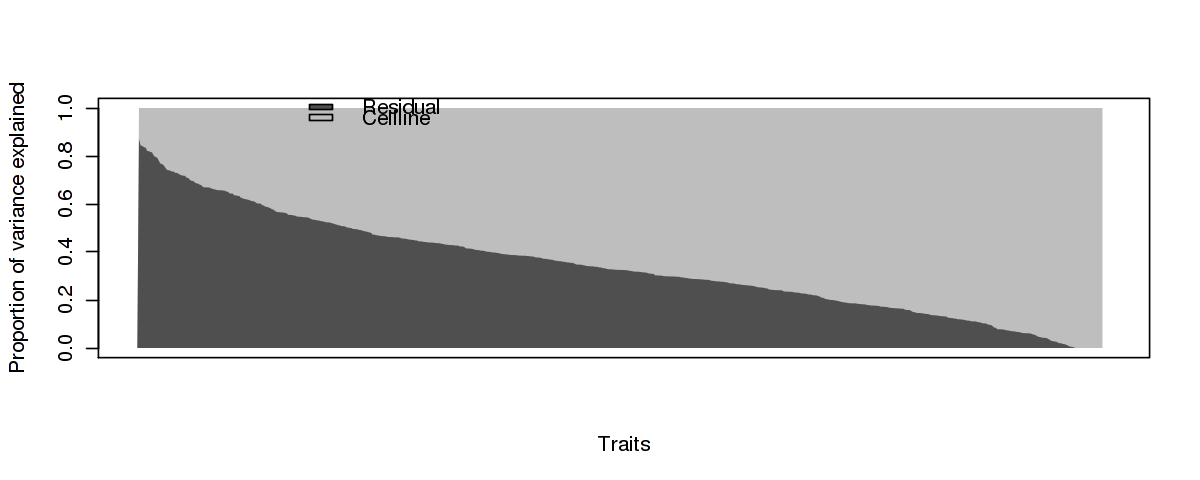

In [133]:
options(repr.plot.height = 4, repr.plot.width = 10)

plot(0, type = 'n', xlim = c(0,ncol(pilot.prop.var) + 5), ylim = c(0,1), xaxt = 'n', xlab = "Traits", ylab = "Proportion of variance explained")
polygon(x=c(0,1:ncol(pilot.prop.var),ncol(pilot.prop.var)), y = c(0,pilot.prop.var.cellline[order(pilot.prop.var.residual)],0) + c(0,pilot.prop.var.residual[order(pilot.prop.var.residual)],0), col="gray", border=NA)
polygon(x=c(0,1:ncol(pilot.prop.var),ncol(pilot.prop.var)), y = c(0,pilot.prop.var.cellline[order(pilot.prop.var.residual)],0), col="gray31", border=NA)
legend(ncol(pilot.prop.var)-500,1.05,legend=row.names(pilot.prop.var)[c(2,1)], bty = 'n', fill = c("gray31", "gray"))

In [135]:
pilot.pca.6.isolated <- irlba::prcomp_irlba(pilot.data.6.subset, 30)

In [137]:
head(pilot.metadata.6)

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_timepoint
<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>
BR00103267,A01,BR00103267,cmQTL1-4_mt,A01,5000,A,6
BR00103267,A02,BR00103267,cmQTL1-4_mt,A02,5000,A,6
BR00103267,A03,BR00103267,cmQTL1-4_mt,A03,15000,B,6
BR00103267,A04,BR00103267,cmQTL1-4_mt,A04,15000,B,6
BR00103267,A05,BR00103267,cmQTL1-4_mt,A05,5000,E,6
BR00103267,A06,BR00103267,cmQTL1-4_mt,A06,5000,E,6


In [138]:
pilot.pvca.6 <- do_pvca(as.matrix(pilot.pca.6$x), pilot.metadata.6.subset, 30)


BEGIN ITER 1
singular fit
BEGIN ITER 2
BEGIN ITER 3
BEGIN ITER 4
BEGIN ITER 5
BEGIN ITER 6
BEGIN ITER 7
BEGIN ITER 8
BEGIN ITER 9
BEGIN ITER 10
BEGIN ITER 11
BEGIN ITER 12
BEGIN ITER 13
BEGIN ITER 14
BEGIN ITER 15
BEGIN ITER 16
singular fit
BEGIN ITER 17
singular fit
BEGIN ITER 18
singular fit
BEGIN ITER 19
BEGIN ITER 20
singular fit
BEGIN ITER 21
singular fit
BEGIN ITER 22
singular fit
BEGIN ITER 23
singular fit
BEGIN ITER 24
singular fit
BEGIN ITER 25
singular fit
BEGIN ITER 26
singular fit
BEGIN ITER 27
singular fit
BEGIN ITER 28
singular fit
BEGIN ITER 29
singular fit
BEGIN ITER 30
singular fit


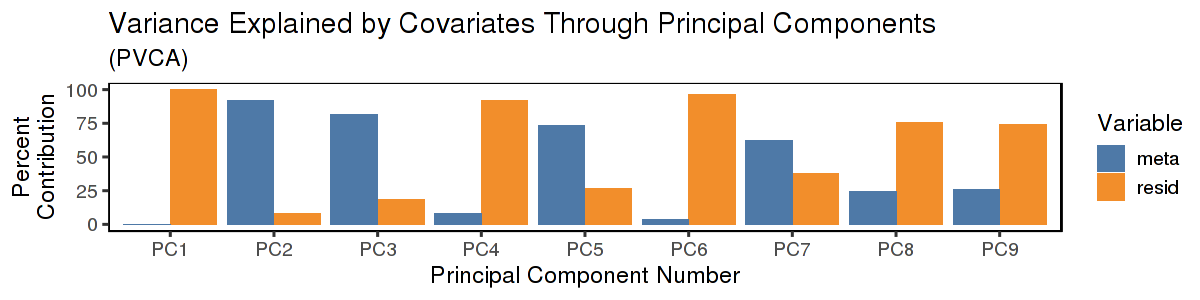

In [139]:
options(repr.plot.height = 2.5, repr.plot.width = 10)
pilot.pvca.6 %>% 
    subset(pc < 10) %>%
    ggplot(aes(pc_str, val * 100, fill = variable)) + 
#     ggplot(aes(reorder(sprintf("%s (%.0f%%)", pc_str, 100 * var_explained), pc), var_explained * val * 100, fill = variable_nice)) + 
#     ggplot(aes(reorder(pc_str, pc), val * 100, fill = variable_nice)) + 
        geom_bar(stat = "identity", position = position_dodge()) + 
        theme_tufte(base_size = 14) + theme(panel.background = element_rect()) + 
        scale_fill_tableau() + 
        labs(y = "Percent\nContribution", x = "Principal Component Number", fill = "Variable", 
             title = "Variance Explained by Covariates Through Principal Components", 
             subtitle = "(PVCA)") 

## Only colony

### Variance analysis, by condition

In [142]:
timepoint.6.colony <- sapply(c(5000, 10000, 15000, 20000), run_var_condition, pilot.data.6.colony, pilot.metadata.6.colony)

In [146]:
timepoint.24.colony <- sapply(c(1000, 2000, 3000, 4000), run_var_condition, pilot.data.24.colony, pilot.metadata.24.colony)

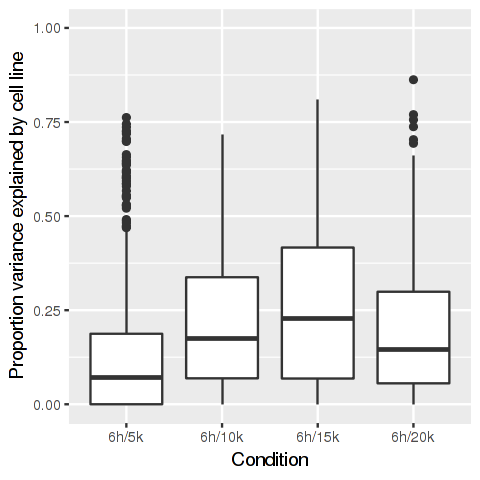

In [155]:
options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(melt(cbind(timepoint.6.colony)), aes(x = factor(Var2), y = value)) +
    geom_boxplot() +
    xlab("Condition") + ylab("Proportion variance explained by cell line") +
    scale_x_discrete(labels = c("6h/5k", "6h/10k", "6h/15k", "6h/20k")) +
    ylim(0,1)

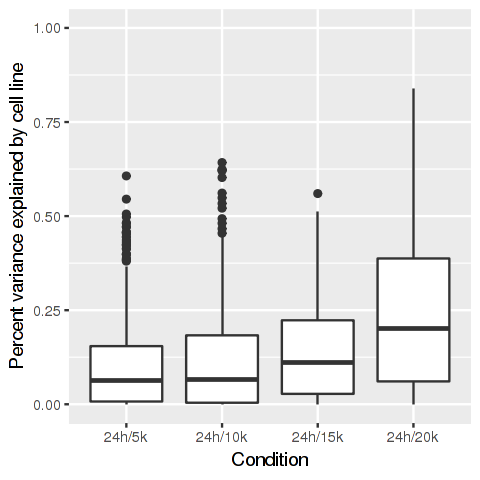

In [152]:
options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(melt(cbind(timepoint.24.colony)), aes(x = factor(Var2), y = value)) +
    geom_boxplot() +
    xlab("Condition") + ylab("Percent variance explained by cell line") +
    scale_x_discrete(labels = c("24h/5k", "24h/10k", "24h/15k", "24h/20k")) +
    ylim(0,1)

## PCA of traits

In [29]:
pilot.traits.pca.6 <- prcomp(pilot.data.6)

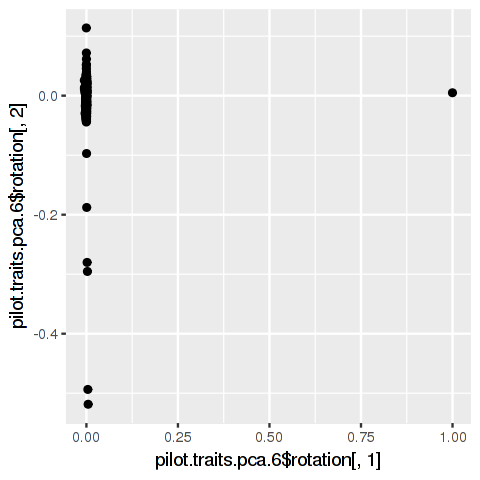

In [30]:
## Plotting first two PCs shows that one trait may be an outlier
ggplot(as.data.frame(pilot.traits.pca.6$rotation), aes(x = pilot.traits.pca.6$rotation[,1], y = pilot.traits.pca.6$rotation[,2])) +
       geom_point()

In [170]:
which(pilot.traits.pca.6$rotation[,1] > .75)

Nuclei_Correlation_Costes_DNA_ER 
                             396

In [31]:
## Remove outlier trait
pilot.traits.pca.6 <- prcomp(pilot.data.6[,-which(pilot.traits.pca.6$rotation[,1] > .75)])

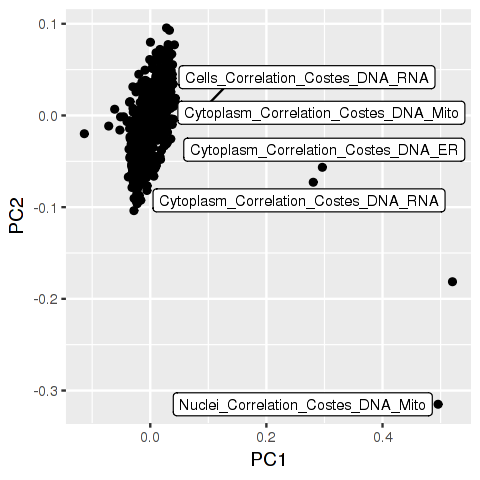

In [32]:
labels <- rep("", times = ncol(pilot.data.6))
labels[pilot.traits.pca.6$rotation[,1] > .08] <- colnames(pilot.data.6)[pilot.traits.pca.6$rotation[,1] > .08]
labels <- labels[-396]
ggplot(as.data.frame(pilot.traits.pca.6$rotation), aes(x = pilot.traits.pca.6$rotation[,1], y = pilot.traits.pca.6$rotation[,2], label = labels)) +
    geom_point() +
    geom_label_repel(size = 3, force = 5) +
    xlab("PC1") + ylab("PC2")


In [189]:
which(pilot.traits.pca.6$rotation[,1] > .5)

Nuclei_Correlation_Costes_DNA_RNA 
                              397